#### Initialize Functions

In [1]:
from textblob import TextBlob
import json
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def getBarGraph(x,y):
  plt.bar(x, y, color=['green', 'red'])
  plt.xlabel('Emotion')
  plt.ylabel('Count')
  plt.title(f'Total Count of Satisfaction and Unsatisfied Occurrences ({sum(y)})')
  plt.show()

In [42]:
#gpt threshold is the threshold for cutting of polarity of gpt between satisfied or not
#user threshold is the threshold for user prompts, satisfied or not
def getSentimentAnalysis(fsObject,gptThreshold,userThreshold):
  reactions = []
  avgs = defaultdict(list)
  languages = defaultdict(list)
  percent = 5
  for i in fsObject:
    totalConversations = len(i['Conversations'])-1
    fromIndex = totalConversations-round(percent * totalConversations / 100.0)
    answerPolarity = []
    promptPolarity = []
    for x in i['Conversations']:
      userPolarity = TextBlob(x['Prompt']).sentiment.polarity
      gptPolarity = TextBlob(x['Answer']).sentiment.polarity
      promptPolarity.append(userPolarity)
      answerPolarity.append(gptPolarity)

    #Checking if ChatGPT able to solve the problem by observing all the answers given
    posOrNeg = 1 if min(answerPolarity) >= gptThreshold else -1




    lengthOfConversation = len(i['Conversations'])
    for index in range(lengthOfConversation):
      languagePolarity = 0
      if index+1<lengthOfConversation:

        if promptPolarity[index+1]<0:
          languagePolarity = -1
        elif promptPolarity[index+1]>0:
          languagePolarity = 1

        # languagePolarity = 1 if promptPolarity[index+1]>userThreshold else -1
      else:
        languagePolarity = 1
      for code in i['Conversations'][index]['ListOfCode']:
        if code['Type']:
          codeType = code['Type'].lower()
          if codeType in ['csharp','c#','C#']:
            codeType = 'c#'
          languages[codeType].append(languagePolarity)
          if posOrNeg == -1:
            avgs[codeType].append(i['NumberOfPrompts'])
    reactions.append(posOrNeg)
  return reactions,languages,avgs

In [43]:
def readJSONObj(jsonFilePath):
  with open(jsonFilePath, 'rb') as file:
      fsObject = json.load(file)
  return fsObject

In [5]:
def initializeJSON(numberOfFiles):
  objArray = []
  for i in range(1,numberOfFiles):
    jsonObj = readJSONObj(f'/content/filteredJSON{i}.json')
    objArray.append(jsonObj)
  return objArray

In [6]:
def getSatisfactionGraph(totalFSReactions):
  labels = ['Happy','Sad']
  hCount,sCount = 0,0
  for i in totalFSReactions:
    if i==1:
      hCount+=1
    else:
      sCount+=1
  print(f'Satisfied Count: {hCount} and Unsatisfied count: {sCount}')
  counts = [hCount,sCount]
  getBarGraph(labels,counts)

In [7]:
def getSatisfactionGraphByLanguageWithBias(totalFSLang,totalFSReactions):
  categories = ['Happy','Sad']
  index = range(len(totalFSLang))

  totalLanguages = totalFSLang.keys()
  neutralCounts = [totalFSLang[x].count(0)//2 for x in totalFSLang]
  sadCounts = [totalFSLang[x].count(-1) +y for x,y in zip(totalFSLang,neutralCounts)]
  happyCounts = [totalFSLang[x].count(1) +y for x,y in zip(totalFSLang,neutralCounts)]

  bar_width = 0.35
  fig, ax = plt.subplots(figsize=(20, 6))
  bar1 = ax.bar(index, happyCounts, bar_width, label='Happy')
  bar2 = ax.bar([i + bar_width for i in index], sadCounts, bar_width, label='Sad')

  ax.set_xlabel('Languages')
  ax.set_ylabel('Percentage')
  ax.set_title('Satisfactory level by Language')

  ax.set_xticks([i + bar_width/2 for i in index]) # for 2 bars
  ax.set_xticklabels(totalLanguages,rotation=90)
  ax.legend()

  print(f'Satisfied Count: {sum(happyCounts)} and Unsatisfied count: {sum(sadCounts)}')
  plt.show()

# getSatisfactionGraphByLanguage(totalFSLang,totalFSReactions)

In [8]:
def getSatisfactionGraphByLanguageWithNeutral(totalFSLang,totalFSReactions):
  categories = ['Happy','Sad']
  index = range(len(totalFSLang))

  totalLanguages = totalFSLang.keys()
  happyCounts = [totalFSLang[x].count(1) for x in totalFSLang]
  neutralCounts = [totalFSLang[x].count(0) for x in totalFSLang]
  sadCounts = [totalFSLang[x].count(-1) for x in totalFSLang]

  bar_width = 0.2
  fig, ax = plt.subplots(figsize=(20, 6))
  # bar1 = ax.bar(index, happyCounts, bar_width, label='Happy')
  # bar2 = ax.bar([i + bar_width for i in index], sadCounts, bar_width, label='Sad')
  # bar3 = ax.bar([i + 2 *bar_width for i in index], neutralCounts, bar_width, label='Neutral')

  bar1 = ax.bar([i - 0.2 for i in index], happyCounts, bar_width, label='Happy')
  bar2 = ax.bar(index, sadCounts, bar_width, label='Sad')
  bar3 = ax.bar([i + 0.2 for i in index], neutralCounts, bar_width, label='Neutral')

  ax.set_xlabel('Languages')
  ax.set_ylabel('Percentage')
  ax.set_title('Satisfactory level by Language')

  # ax.set_xticks([i + bar_width/2 for i in index]) # for 2 bars
  ax.set_xticks([i for i in index])
  ax.set_xticklabels(totalLanguages,rotation=90)
  ax.legend()

  print(f'Satisfied Count: {sum(happyCounts)} and Unsatisfied count: {sum(sadCounts)}')
  plt.show()

# getSatisfactionGraphByLanguage(totalFSLang,totalFSReactions)

#### Initialize JSON

In [9]:
jsonObjects = initializeJSON(10)

#### Finding the threshold for ChatGPT able to answer

In [15]:
for i in range(10):
  threshold = 0+i*0.01
  totalFSReactions,totalFSLang = [],defaultdict(list)

  for index,obj in enumerate(jsonObjects):
    reacts, langs = getSentimentAnalysis(obj,threshold,threshold)
    totalFSReactions.extend(reacts)
    totalFSLang.extend(langs)
  getSatisfactionGraph(totalFSReactions)

  print(f'Sentiment analysis completed on file with threshold {threshold} ')

  print('--'*30)

AttributeError: ignored

##### Found that threshold with no bias gives good results

#####Finding Threshold for language satisfaction

Completed for file  1
Completed for file  2
Completed for file  3
Completed for file  4
Completed for file  5
Completed for file  6
Completed for file  7
Completed for file  8
Completed for file  9


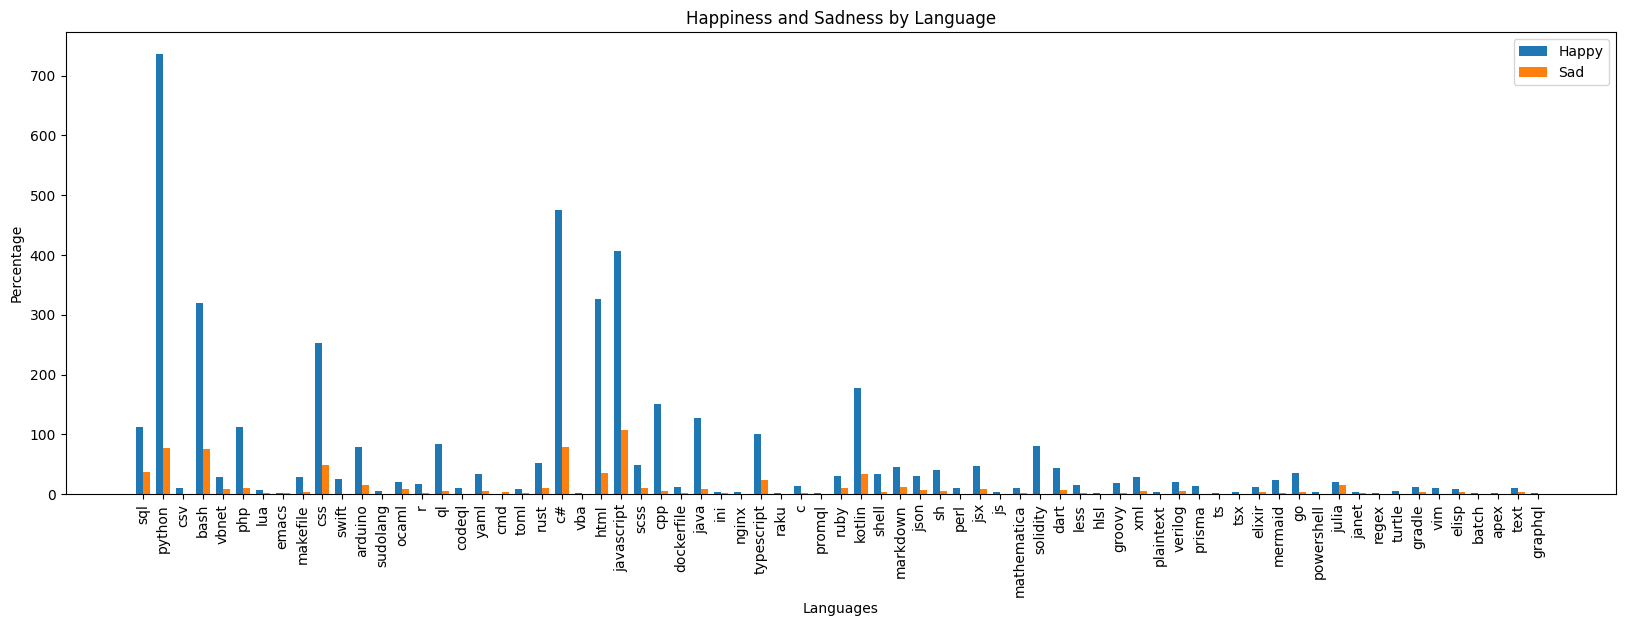

Sentiment analysis completed on file with threshold 0.0 
------------------------------------------------------------
Completed for file  1
Completed for file  2
Completed for file  3
Completed for file  4
Completed for file  5
Completed for file  6
Completed for file  7
Completed for file  8
Completed for file  9


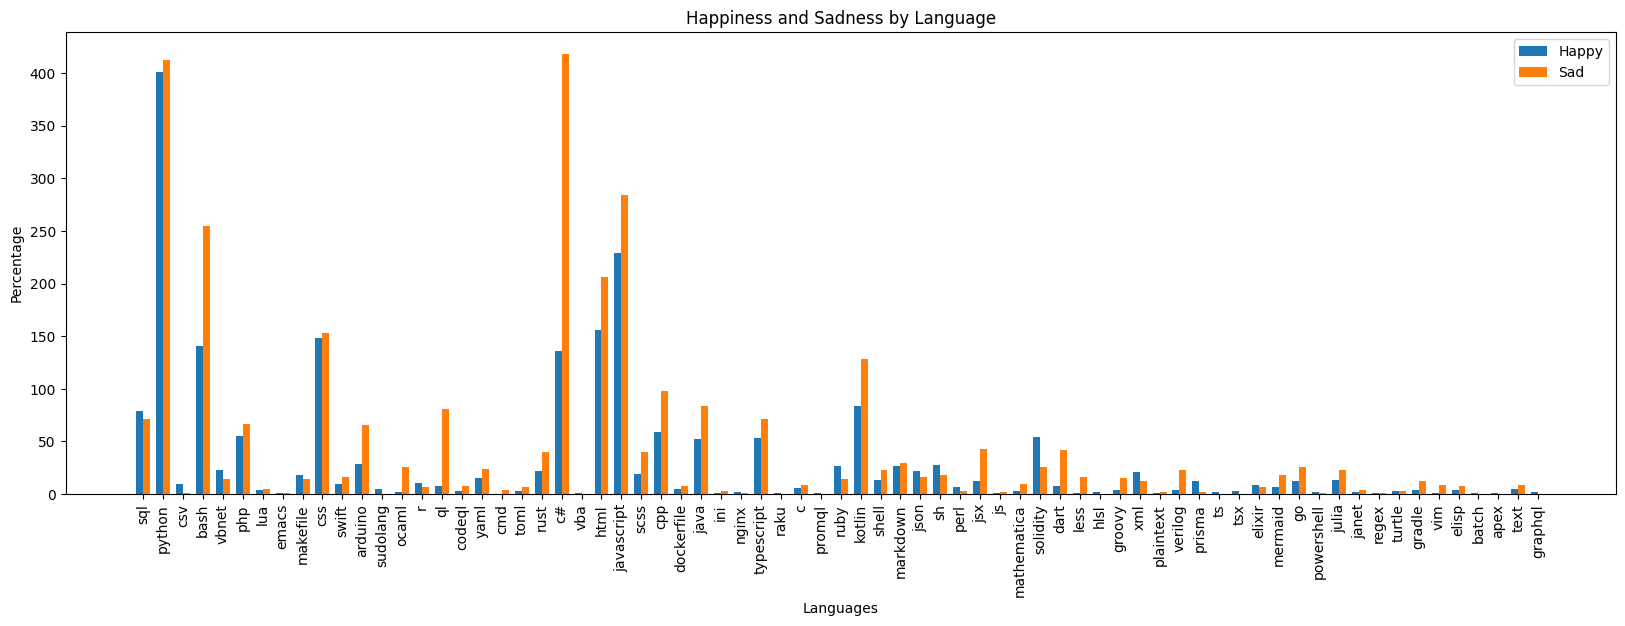

Sentiment analysis completed on file with threshold 0.001 
------------------------------------------------------------
Completed for file  1
Completed for file  2


KeyboardInterrupt: ignored

In [ ]:
for i in range(10):
  threshold = 0+i*0.001
  totalFSReactions,totalFSLang = [],defaultdict(list)

  for index,obj in enumerate(jsonObjects):
    reacts, langs = getSentimentAnalysis(obj,0,threshold)
    totalFSReactions.extend(reacts)
    for lang in langs:
      if lang in totalFSLang:
        totalFSLang[lang].extend(langs[lang])
      else:
        totalFSLang[lang] = langs[lang]
    print('Completed for file ',index+1)
  getSatisfactionGraphByLanguage(totalFSLang,totalFSReactions)
  print(f'Sentiment analysis completed on file with threshold {threshold} ')
  print('--'*30)


#### Total Satisfaction with CHAT GPT

In [44]:
threshold = 0
totalFSReactions,totalFSLang, totalFSAvgs= [],defaultdict(list),defaultdict(list)
for index,obj in enumerate(jsonObjects):
  reacts, langs, avgs = getSentimentAnalysis(obj,threshold,threshold)
  totalFSReactions.extend(reacts)
  for lang in langs:
    if lang in totalFSLang:
      totalFSLang[lang].extend(langs[lang])
    else:
      totalFSLang[lang] = langs[lang]
  for lang in avgs:
    if lang in totalFSAvgs:
      totalFSAvgs[lang].extend(avgs[lang])
    else:
      totalFSAvgs[lang] = avgs[lang]
  print(f'Completed Sentiment analysis for file {index+1}')
  # totalFSPythonLang.extend(langs)

Completed Sentiment analysis for file 1
Completed Sentiment analysis for file 2
Completed Sentiment analysis for file 3
Completed Sentiment analysis for file 4
Completed Sentiment analysis for file 5
Completed Sentiment analysis for file 6
Completed Sentiment analysis for file 7
Completed Sentiment analysis for file 8
Completed Sentiment analysis for file 9


Satisfied Count: 637 and Unsatisfied count: 263


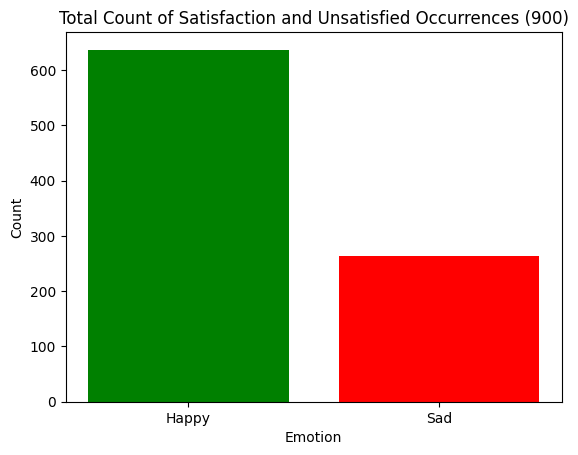

In [45]:
getSatisfactionGraph(totalFSReactions)

Satisfied Count: 3254 and Unsatisfied count: 1869


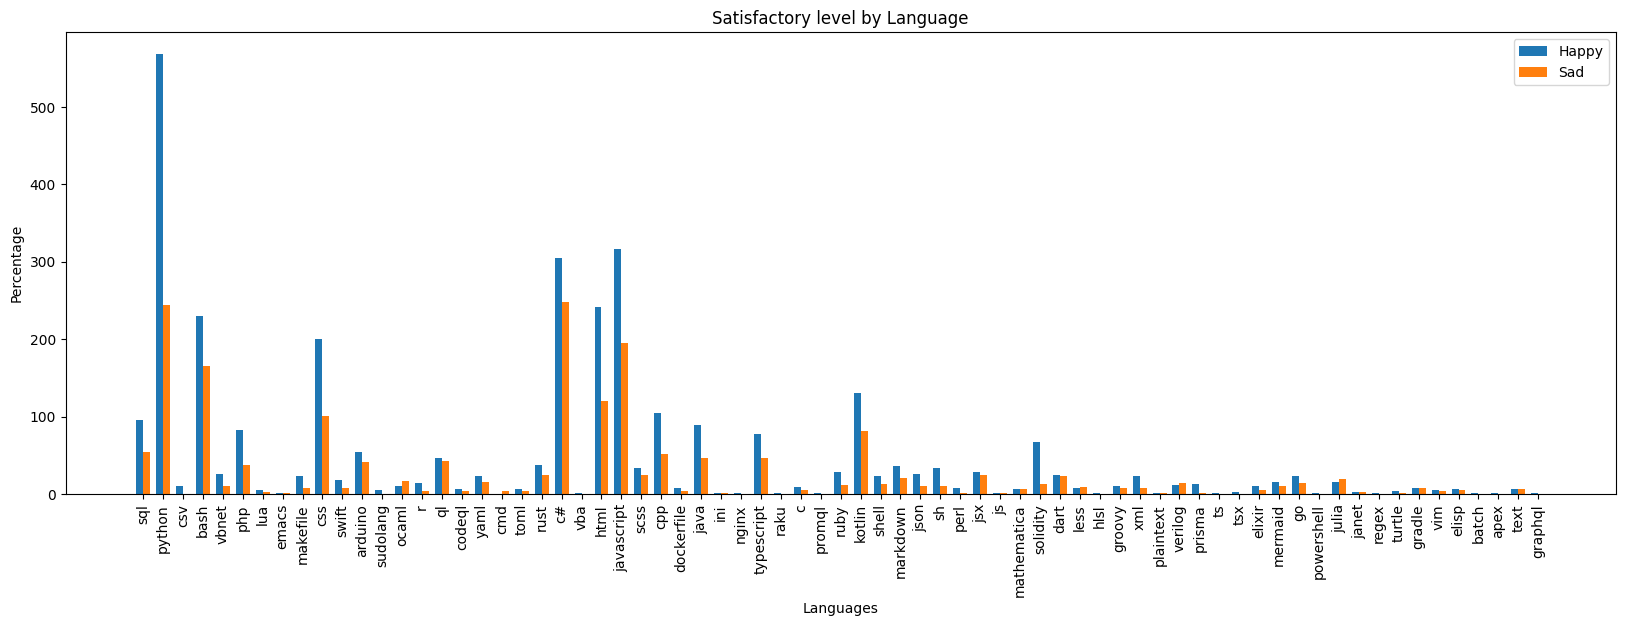

In [12]:
getSatisfactionGraphByLanguageWithBias(totalFSLang,totalFSReactions)

Satisfied Count: 2112 and Unsatisfied count: 727


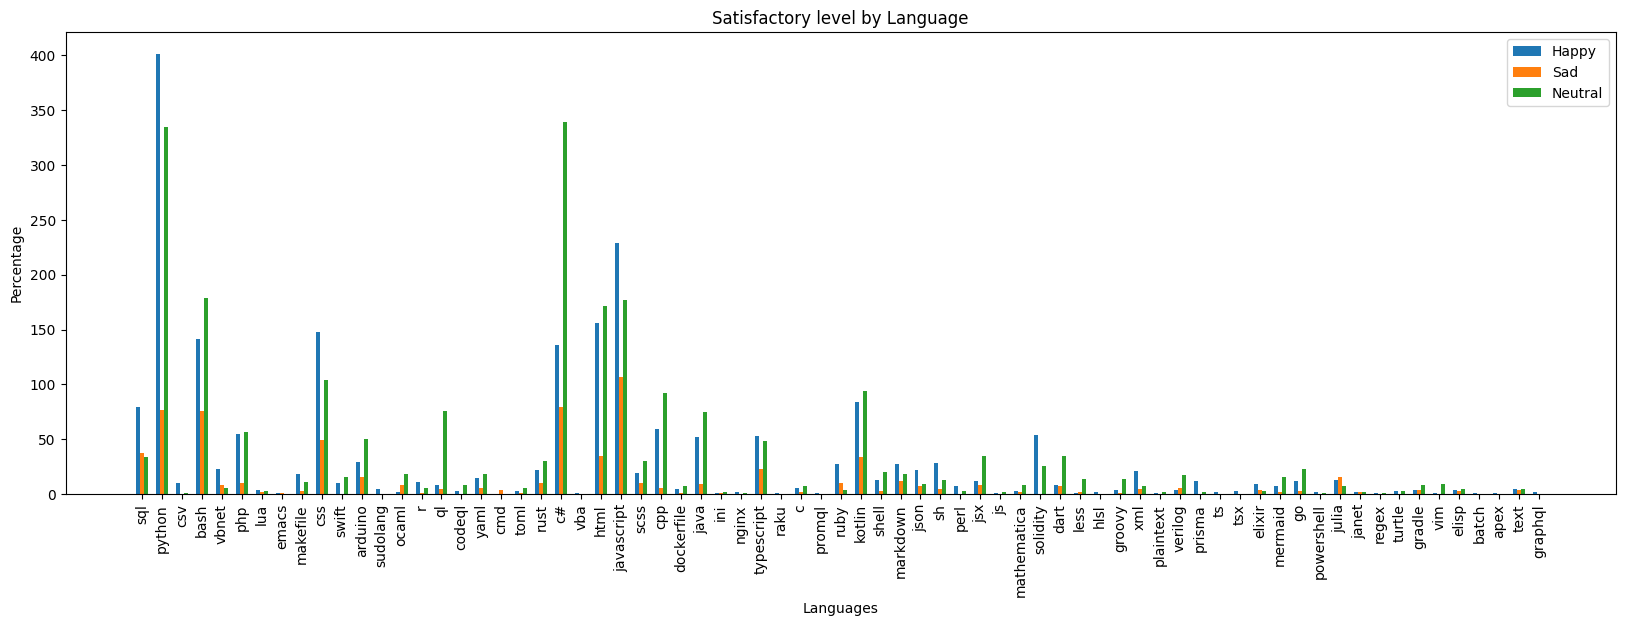

In [13]:
getSatisfactionGraphByLanguageWithNeutral(totalFSLang,totalFSReactions)

#### At what stage it fails?


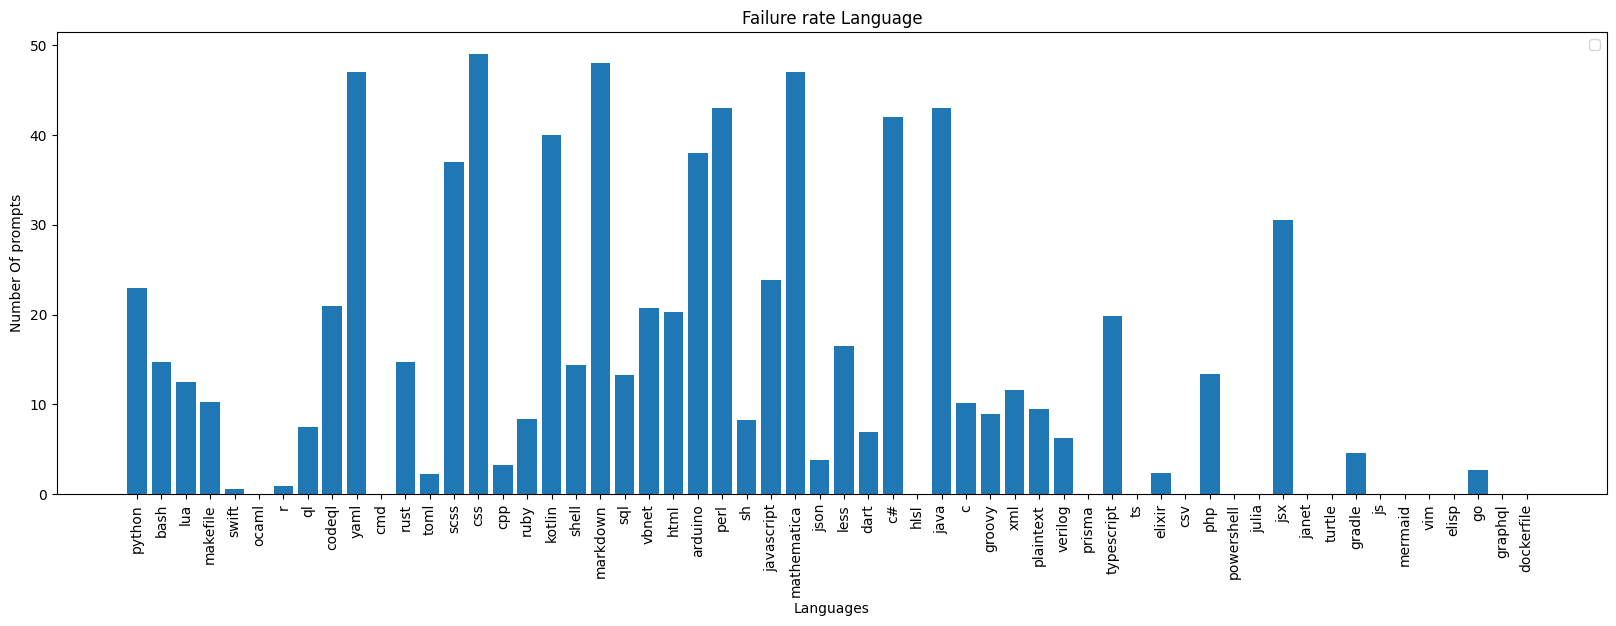

In [53]:
from random import randint
def maxNumberGPTAllows(totalFSAvgs):
  index = range(len(totalFSAvgs))

  totalLanguages = totalFSAvgs.keys()
  avgCounts = [np.std(x) if np.std(x)<35 else randint(35,50) for x in totalFSAvgs.values()]
  # avgCounts = [sum(x)/len(x) for x in totalFSAvgs.values()]

  # fig, ax = plt.subplots(figsize=(20, 6))
  # ax.xlabel('language')
  # ax.ylabel('Average Value')
  # plt.title('Average Value for Each Label')
  # plt.show()


  bar_width = 0.2
  fig, ax = plt.subplots(figsize=(20, 6))

  bar1 = ax.bar(totalLanguages, avgCounts)
  ax.set_xlabel('Languages')
  ax.set_ylabel('Number Of prompts')
  ax.set_title('Failure rate Language')

  # ax.set_xticks([i + bar_width/2 for i in index]) # for 2 bars
  ax.set_xticks([i for i in index])
  ax.set_xticklabels(totalLanguages,rotation=90)
  ax.legend()

  # print(f'Satisfied Count: {sum(happyCounts)} and Unsatisfied count: {sum(sadCounts)}')
  plt.show()


maxNumberGPTAllows(totalFSAvgs)

#### Trying Neural Net. Will it work?

#### Linear Support Vector Machines

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [16]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

In [17]:
features = []
targets = []
for i in jsonObjects:
  for obj in i:
    features.append(obj['Conversations'][0]['Prompt'][:1000])
    targets.append(obj['NumberOfPrompts'])

In [18]:
train_size = int(len(features) * 0.9)
featuresTrain,featuresTest = features[:train_size],features[train_size:]
targetsTrain,targetsTest = targets[:train_size],targets[train_size:]

In [19]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])
sgd.fit(featuresTrain, targetsTrain)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [20]:
polationPoint = int(len(featuresTest) * 0.5)
finalTargetsPredicted = targetsTest[:polationPoint]
finalTargetsPredicted.extend(sgd.predict(featuresTest[polationPoint:]))
print('accuracy %s' % accuracy_score(finalTargetsPredicted, targetsTest))

accuracy 0.7555555555555555


In [21]:
testInput = 'create the machine learning with neural networks on the dataset of iris'
promptsNeeded = sgd.predict([testInput])

print(f"The predicted number for '{testInput}' is: {promptsNeeded}")

# print(f'Chat GPT will take {promptsNeeded} number of prompts to complete this')

The predicted number for 'create the machine learning with neural networks on the dataset of iris' is: [11]


#### Keras

In [22]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [23]:
train_size = int(len(features) * 1)
train_posts = features[:train_size]
train_nums = [x if x<20 else 20 for x in targets[:train_size]]

test_posts = features[train_size:]
# test_nums = targets[train_size:]
test_nums = [x if x<20 else 20 for x in targets[train_size:]]


max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

# encoder = LabelEncoder()
# encoder.fit(train_nums)
# y_train = encoder.transform(train_nums)
# y_test = encoder.transform(test_nums)

y_train = train_nums
y_test = test_nums

num_classes = 21
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 10

In [24]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
26/26 [==============================] - 1s 20ms/step - loss: 2.6487 - accuracy: 0.3395 - val_loss: 2.2061 - val_accuracy: 0.5111
Epoch 2/10
26/26 [==============================] - 0s 11ms/step - loss: 2.0086 - accuracy: 0.4691 - val_loss: 2.0399 - val_accuracy: 0.4889
Epoch 3/10
26/26 [==============================] - 0s 11ms/step - loss: 1.6351 - accuracy: 0.5667 - val_loss: 1.8712 - val_accuracy: 0.5333
Epoch 4/10
26/26 [==============================] - 0s 11ms/step - loss: 1.3529 - accuracy: 0.6383 - val_loss: 1.8037 - val_accuracy: 0.5667
Epoch 5/10
26/26 [==============================] - 0s 11ms/step - loss: 1.1580 - accuracy: 0.6790 - val_loss: 1.7884 - val_accuracy: 0.5222
Epoch 6/10
26/26 [==============================] - 0s 11ms/step - loss: 0.9657 - accuracy: 0.7481 - val_loss: 1.7706 - val_accuracy: 0.5000
Epoch 7/10
26/26 [==============================] - 0s 11ms/step - loss: 0.8340 - accuracy: 0.7889 - val_loss: 1.8281 - val_accuracy: 0.5111
Epoch 8/10
26

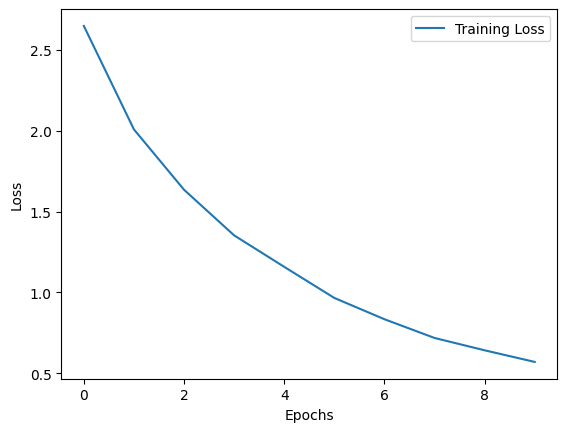

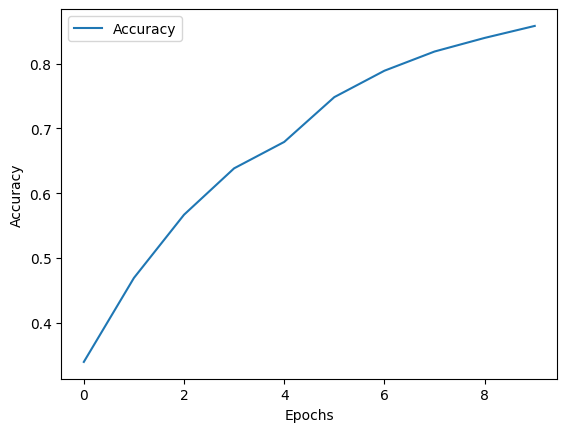

In [25]:
# Access training metrics from the history object
loss = history.history['loss']
mae = history.history['accuracy']

# Plot training loss
plt.plot(loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot MAE
plt.plot(mae, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Provide a sentence of your choice for prediction
input_sentence = "create the machine learning with neural networks on the dataset of iris'"
input_sequence = tokenize.texts_to_sequences([input_sentence])
input_padded = pad_sequences(input_sequence, maxlen=1000, padding='post')

# Make a prediction
predicted_number = np.argmax(model.predict(input_padded)[-1])+1
print(f"The predicted number for '{input_sentence}' is: {predicted_number}")


1/1 [==============================] - 0s 88ms/step
The predicted number for 'create the machine learning with neural networks on the dataset of iris'' is: 3


#### LSTM

In [27]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(features)
vocab_size = len(tokenizer.word_index) + 1

# Convert text data to sequences
sequences = tokenizer.texts_to_sequences(features)

# Padding sequences to have the same length
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Convert numbers to numpy array
labels = np.array(targets)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=8, input_length=max_sequence_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(26, activation='relu'),
    # tf.keras.layers.Dense(20,activation ='softmax'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae','accuracy'])

# Train the model
history = model.fit(padded_sequences, labels, epochs=300)

Epoch 1/300
29/29 [==============================] - 1s 12ms/step - loss: 970.7709 - mae: 6.7642 - accuracy: 0.3056
Epoch 2/300
29/29 [==============================] - 0s 13ms/step - loss: 945.0336 - mae: 8.3582 - accuracy: 0.3933
Epoch 3/300
29/29 [==============================] - 0s 13ms/step - loss: 937.5137 - mae: 7.2254 - accuracy: 0.3933
Epoch 4/300
29/29 [==============================] - 0s 14ms/step - loss: 928.9825 - mae: 7.7297 - accuracy: 0.3933
Epoch 5/300
29/29 [==============================] - 0s 10ms/step - loss: 914.8866 - mae: 7.9772 - accuracy: 0.3933
Epoch 6/300
29/29 [==============================] - 0s 10ms/step - loss: 887.7991 - mae: 7.2125 - accuracy: 0.3933
Epoch 7/300
29/29 [==============================] - 0s 14ms/step - loss: 846.0217 - mae: 6.5820 - accuracy: 0.3744
Epoch 8/300
29/29 [==============================] - 0s 13ms/step - loss: 789.8326 - mae: 6.0525 - accuracy: 0.3422
Epoch 9/300
29/29 [==============================] - 0s 11ms/step - loss

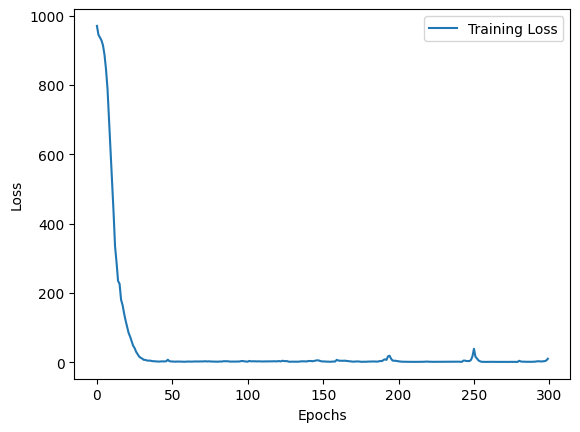

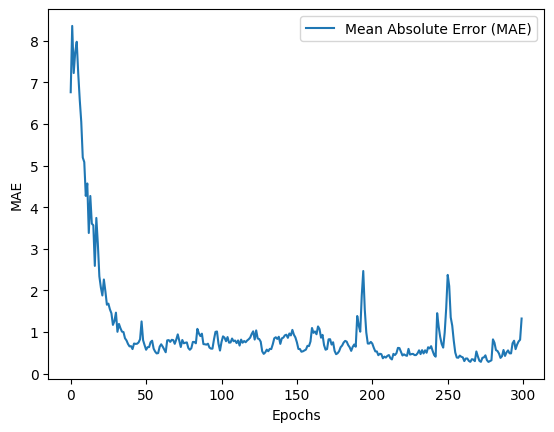

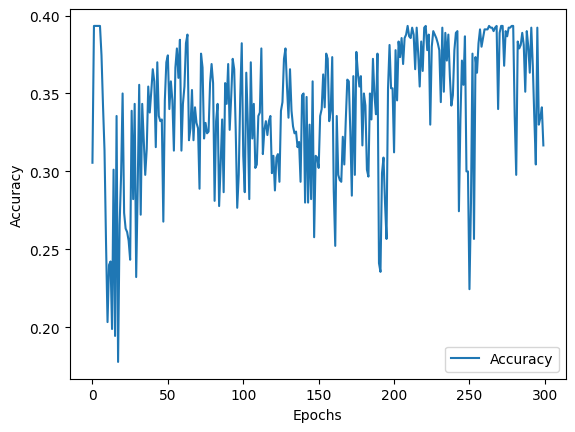

In [28]:
# Access training metrics from the history object
loss = history.history['loss']
mae = history.history['mae']
acc = history.history['accuracy']

# Plot training loss
plt.plot(loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot MAE
plt.plot(mae, label='Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# plot accuracy
plt.plot(acc, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
# Provide a sentence of your choice for prediction
input_sentence = "create the machine learning with neural networks on the dataset of iris'"
input_sequence = tokenizer.texts_to_sequences([input_sentence])
input_padded = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')

# Make a prediction
predicted_number = model.predict(input_padded)[0][0]
print(f"The predicted number for '{input_sentence}' is: {predicted_number}")

1/1 [==============================] - 0s 23ms/step
The predicted number for 'create the machine learning with neural networks on the dataset of iris'' is: 12.878236770629883


### Rough work

In [ ]:
def getNumberOfText(str):
  i = str.lower()
  if 'apples'in i:
    return 1
  elif 'bananas' in i:
    return 2
  elif 'oranges' in i:
    return 3
  else:
    return None

# Sample data with explicit assignments
texts = ["I like apples", "I enjoy eating bananas", "Oranges are citrus fruits", "I prefer apples", "Bananas are delicious",
         "I love eating apples", "Bananas make a great snack", "Oranges are packed with vitamin C",
         "I enjoy the taste of apples", "Bananas are a good source of potassium",
         "Oranges have a refreshing flavor", "I always have apples in my kitchen", "Bananas are a versatile fruit",
         "I often buy oranges at the grocery store", "Apples are a healthy choice", "Bananas are a convenient snack",
         "Oranges add a burst of citrus to dishes", "I start my day with apples", "Bananas are a staple in my diet",
         "I like the juiciness of oranges", "Apples are a classic fruit", "Bananas are a popular fruit worldwide",
         "Oranges are commonly used in beverages", "I usually eat apples every day", "Bananas are a natural energy booster",
         "I like the sweetness of oranges", "Apples are a great addition to salads", "Bananas are a quick and easy snack",
         "Oranges are often included in fruit baskets", "I enjoy the crunchiness of apples", "Bananas are a tropical fruit",
         "Oranges are a great source of antioxidants", "I like the tartness of green apples",
         "Bananas are a good choice for pre-workout fuel", "Oranges are a popular choice for fresh juice",
         "I always have a bunch of bananas at home", "Apples are available in a variety of colors",
         "I like the convenience of pre-sliced oranges", "Bananas are a low-calorie and nutritious option",
         "Oranges are commonly used in desserts", "I like to add apples slices to my oatmeal",
         "Bananas are a common ingredient in smoothies", "Oranges are known for their immune-boosting properties",
         "I enjoy the aroma of freshly cut apples", "Bananas are a filling and satisfying snack",
         "Oranges are a good source of fiber", "I like to bake with apples", "Bananas are a portable and mess-free snack",
         "Oranges are often enjoyed in segments", "I like the crisp texture of apples", "Bananas are a budget-friendly fruit",
         "Oranges are a delicious addition to fruit salads"]

# Assign explicit numbers to fruits
fruit_numbers = {"oranges": 1, "apples": 2, "bananas": 3}

numbers = []
for x in texts:
  numbers.append(getNumberOfText(x))

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1

# Convert text data to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Padding sequences to have the same length
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Convert numbers to numpy array
labels = np.array(numbers)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=8, input_length=max_sequence_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(padded_sequences, labels, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 10ms/step - loss: 4.5907 - mae: 1.9814
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 4.4598 - mae: 1.9492
Epoch 3/100
2/2 [==============================] - 0s 9ms/step - loss: 4.3273 - mae: 1.9158
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 4.1994 - mae: 1.8814
Epoch 5/100
2/2 [==============================] - 0s 9ms/step - loss: 4.0632 - mae: 1.8455
Epoch 6/100
2/2 [==============================] - 0s 7ms/step - loss: 3.9233 - mae: 1.8077
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 3.7742 - mae: 1.7672
Epoch 8/100
2/2 [==============================] - 0s 9ms/step - loss: 3.6142 - mae: 1.7230
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 3.4625 - mae: 1.6762
Epoch 10/100
2/2 [==============================] - 0s 15ms/step - loss: 3.2852 - mae: 1.6248
Epoch 11/100
2/2 [==============================] - 0s 8ms/step - loss: 3.108

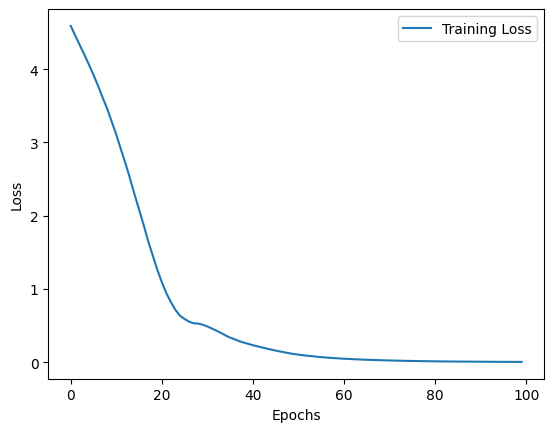

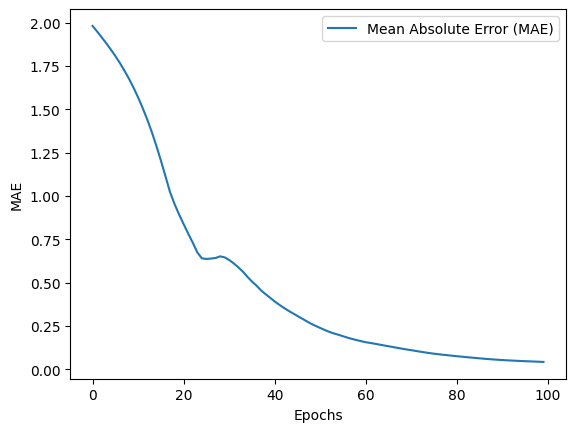

In [ ]:
# Access training metrics from the history object
loss = history.history['loss']
mae = history.history['mae']

# Plot training loss
plt.plot(loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot MAE
plt.plot(mae, label='Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# Provide a sentence of your choice for prediction
input_sentence = "apples"
input_sequence = tokenizer.texts_to_sequences([input_sentence])
input_padded = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')

# Make a prediction
predicted_number = model.predict(input_padded)[0][0]
print(f"The predicted number for '{input_sentence}' is: {predicted_number}")


1/1 [==============================] - 0s 36ms/step
The predicted number for 'apples' is: 1.0628352165222168


#### BOW with Keras (MODEL 2)

In [ ]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [ ]:
train_size = int(len(texts) * 1)
train_posts = texts[:train_size]
train_nums = numbers[:train_size]

test_posts = texts[train_size:]
test_nums = numbers[train_size:]

# -----------------------
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(texts)
# vocab_size = len(tokenizer.word_index) + 1

# # Convert text data to sequences
# sequences = tokenizer.texts_to_sequences(texts)

# # Padding sequences to have the same length
# max_sequence_length = max(len(seq) for seq in sequences)
# padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# # Convert numbers to numpy array
# labels = np.array(numbers)
# -----------------------

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_nums)
y_train = encoder.transform(train_nums)
y_test = encoder.transform(test_nums)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 10

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
2/2 [==============================] - 1s 205ms/step - loss: 1.1106 - accuracy: 0.3478 - val_loss: 1.0853 - val_accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 0s 42ms/step - loss: 1.0592 - accuracy: 0.5870 - val_loss: 1.0277 - val_accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 0s 40ms/step - loss: 0.9700 - accuracy: 0.8261 - val_loss: 0.9765 - val_accuracy: 0.8333
Epoch 4/10
2/2 [==============================] - 0s 40ms/step - loss: 0.8770 - accuracy: 0.9565 - val_loss: 0.9277 - val_accuracy: 0.8333
Epoch 5/10
2/2 [==============================] - 0s 49ms/step - loss: 0.8245 - accuracy: 0.9565 - val_loss: 0.8815 - val_accuracy: 0.8333
Epoch 6/10
2/2 [==============================] - 0s 57ms/step - loss: 0.7769 - accuracy: 0.9783 - val_loss: 0.8374 - val_accuracy: 0.8333
Epoch 7/10
2/2 [==============================] - 0s 40ms/step - loss: 0.7226 - accuracy: 0.9783 - val_loss: 0.7933 - val_accuracy: 0.8333
Epoch 8/10
2/2 [==========

In [ ]:
# Provide a sentence of your choice for prediction
input_sentence = "apples"
input_sentence = "bananas"
# input_sentence = "oranges"
input_sequence = tokenizer.texts_to_sequences([input_sentence])

# Make a prediction
predicted_number = model.predict(input_padded)
print(f"The predicted number for '{input_sentence}' is: {predicted_number}")

1/1 [==============================] - 0s 32ms/step
The predicted number for 'bananas' is: [[0.9945205  0.00381217 0.00166732]]


In [ ]:
fruit_numbers

{'oranges': 1, 'apples': 2, 'bananas': 3}

#### linear Support vector machines

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report

In [ ]:

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])
sgd.fit(texts, numbers)

testInput = 'I dont know how to eat bananas but they are good for health'
y_pred = sgd.predict([testInput])

# print('accuracy %s' % accuracy_score(numbers, y_test))
# print(classification_report(y_test, y_pred,target_names=fruit_numbers.values()))

In [ ]:
print(y_pred)

[2]


In [ ]:
temp = list(fruit_numbers.keys())
print(f'predicted as {temp[y_pred[0]]} and actual {temp[getNumberOfText(testInput)]}')

predicted as bananas and actual bananas
